In [1]:
# imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1748547)

import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

### B2.1 Data loading and inspection

In [3]:
fmnist_data_train = datasets.FashionMNIST('data', train=True, download=True, transform=transform)

In [4]:
fmnist_data_test = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

#### B2.1.a

In [5]:
# dataloaders
trainloader = torch.utils.data.DataLoader(fmnist_data_train, batch_size=128,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(fmnist_data_test, batch_size=4,
                                        shuffle=False, num_workers=2)

In [6]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

##### Reference: http://bit.ly/3ooPQJ7

#### B2.1.b

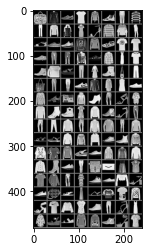

  Bag Shirt Sneaker Shirt Pullover Ankle Boot Trouser Pullover Trouser Pullover  Coat Dress Sandal Pullover Shirt Trouser Sandal Sneaker Sneaker Pullover Pullover Sandal T-shirt/top T-shirt/top Sneaker Trouser Trouser  Coat Sneaker Shirt Dress T-shirt/top Ankle Boot   Bag Sandal Trouser  Coat Ankle Boot   Bag Trouser   Bag Trouser Trouser Sneaker Shirt  Coat T-shirt/top Sneaker Shirt Sneaker   Bag  Coat Ankle Boot Trouser Sandal  Coat Pullover Ankle Boot Ankle Boot Dress  Coat Ankle Boot Sandal Trouser Trouser Trouser  Coat Trouser Shirt Pullover Trouser  Coat Sandal Sandal  Coat  Coat Pullover Sneaker Ankle Boot  Coat Shirt Shirt Pullover Sandal Sneaker  Coat  Coat Shirt  Coat Ankle Boot Sneaker Trouser   Bag   Bag Dress Shirt T-shirt/top Shirt Trouser Dress Sneaker Sneaker T-shirt/top Sandal Sneaker   Bag Sandal Dress Sandal T-shirt/top T-shirt/top Pullover Sandal T-shirt/top Pullover T-shirt/top Ankle Boot Trouser Sandal Dress Dress Sandal Sandal Shirt Pullover Ankle Boot Sandal T-s

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(128)))

##### Reference: https://t.ly/iml0

### B2.3 Logistic Regression

In [8]:
# Imports
import torch
from torch.utils.data import random_split
torch.manual_seed(1748547) # Ucard number

In [9]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001# Other constants
input_size = 28*28
num_classes = 10

In [10]:
# Training validation & test dataset
train_ds, val_ds = random_split(fmnist_data_train, [50000, 10000])

In [11]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size*2)
test_loader = torch.utils.data.DataLoader(fmnist_data_test, batch_size*2)

In [12]:
torch.cuda.device_count()

1

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda', index=0)

In [15]:
import time

In [16]:
from statistics import mean 

#### B2.3.a

In [17]:
class FMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.model(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("\tval_loss: {:.4f}, val_acc: {:.4f}".format(result['val_loss'], result['val_acc']))
    
model = FMnistModel().to(device)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def evaluate(model, val_loader):
    outputs = [model.validation_step((images.to(device), labels.to(device))) for (images, labels) in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    time_list = []
    for epoch in range(epochs):
        # Training Phase 
        running_loss = 0
        running_acc = 0
        start = time.time()
        for batch in train_loader:
            images, labels = batch
            batch = (images.to(device), labels.to(device))
            loss, acc = model.training_step(batch)
            running_loss += loss.item()
            running_acc  += acc.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation phase
        end = time.time()
        print(" Epoch[{}], train_loss : {:.4f}, train_acc: {:.4f} ".format(epoch,
                            running_loss/len(train_loader),running_acc/len(train_loader)))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        time_list.append(end - start)
    train_time = mean(time_list)
    return history, train_time

Metric M1 (training accuracy) and M2 (testing accuracy) are mentioned after every epoch

In [18]:
epochs = 54
lr = 0.1
history1, times = fit(epochs, lr, model, train_loader, val_loader)


 Epoch[0], train_loss : 1.7410, train_acc: 0.7258 
	val_loss: 1.6787, val_acc: 0.7531
 Epoch[1], train_loss : 1.6618, train_acc: 0.7593 
	val_loss: 1.6524, val_acc: 0.7600
 Epoch[2], train_loss : 1.6433, train_acc: 0.7677 
	val_loss: 1.6396, val_acc: 0.7655
 Epoch[3], train_loss : 1.6330, train_acc: 0.7757 
	val_loss: 1.6308, val_acc: 0.7768
 Epoch[4], train_loss : 1.6261, train_acc: 0.7794 
	val_loss: 1.6252, val_acc: 0.7823
 Epoch[5], train_loss : 1.6211, train_acc: 0.7855 
	val_loss: 1.6213, val_acc: 0.7840
 Epoch[6], train_loss : 1.6172, train_acc: 0.7892 
	val_loss: 1.6179, val_acc: 0.7896
 Epoch[7], train_loss : 1.6141, train_acc: 0.7937 
	val_loss: 1.6150, val_acc: 0.7918
 Epoch[8], train_loss : 1.6113, train_acc: 0.7976 
	val_loss: 1.6125, val_acc: 0.7965
 Epoch[9], train_loss : 1.6090, train_acc: 0.8002 
	val_loss: 1.6107, val_acc: 0.7972
 Epoch[10], train_loss : 1.6071, train_acc: 0.8023 
	val_loss: 1.6089, val_acc: 0.8015
 Epoch[11], train_loss : 1.6053, train_acc: 0.8049 
	

Metric M3 (training time)

In [19]:
print('train_time: {:.3f}'.format(times) )

train_time: 8.059


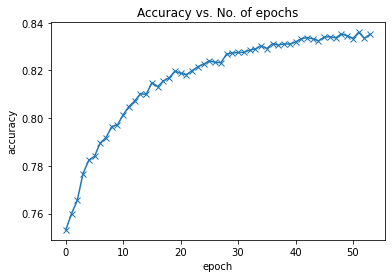

In [20]:
accuracies = [r['val_acc'] for r in history1]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

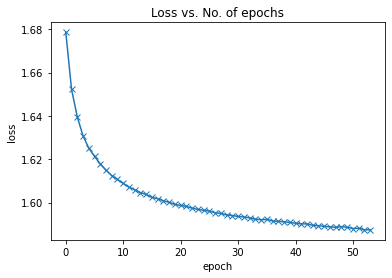

In [21]:
losses = [r['val_loss'] for r in history1]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

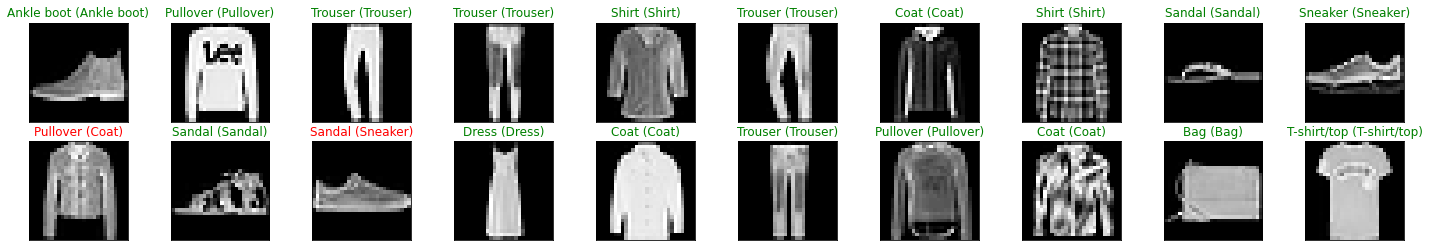

In [22]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' )

dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

#### B2.3.c

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
import pandas as pd

In [25]:
data_train = pd.read_csv("./data/fashion_train.csv")
data_test = pd.read_csv("./data/fashion_test.csv")

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X = data_train.drop(["Id", "Category"], axis=1)
y = data_train["Category"]

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35, random_state=42)

In [29]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [30]:
scaler = StandardScaler()

In [31]:
X_scaled = scaler.fit_transform(X_train)

In [32]:
normalizer = Normalizer()

In [33]:
X_norm = normalizer.fit_transform(X_scaled)

In [34]:
# Logistic regression model with L2 regularization
# Here SAGA has been selected as solver as it supports both l1 and l2 penalties

regr_l2 = LogisticRegression(penalty='l2', random_state=0, solver='saga')

In [35]:
start = time.time()
regr_l2.fit(X_norm, y_train)
end = time.time()

In [36]:
training_accuracy = regr_l2.score(X_norm, y_train)

Metric M1 (training accuracy)

In [37]:
print("training accuracy:\t{:.4f}".format(training_accuracy))

training accuracy:	0.8609


In [38]:
X_val = scaler.transform(X_val)

In [39]:
X_val = normalizer.transform(X_val)

In [40]:
y_pred = regr_l2.predict(X_val)

Metric M2 (testing accuracy)

In [41]:
test_accuracy = regr_l2.score(X_val, y_val)
print("testing accuracy:\t{:.5f}".format(test_accuracy))

testing accuracy:	0.85138


Metric M3 (training time)

In [42]:
print('train_time: {:.3f}'.format(end - start))

train_time: 33.324


In [43]:
from sklearn.metrics import plot_confusion_matrix

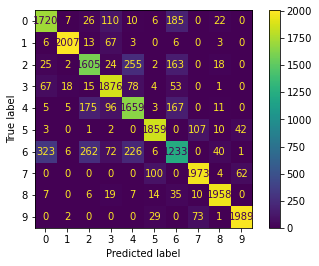

In [44]:
# Plot confusion matrix for predictions of regression model with L2 regularisation
plot_confusion_matrix(regr_l2, X_val, y_val)  
plt.show()  

#### B2.3.b

In [45]:
# Logistic regression model with L2 regularization
# Here SAGA has been selected as solver as it supports both l1 and l2 penalties

regr_l1 = LogisticRegression(penalty='l1', random_state=0, solver='saga', max_iter=200, n_jobs=-1)

In [46]:
start = time.time()

In [47]:
regr_l1.fit(X_norm, y_train)

D:\ACP20GPK\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(max_iter=200, n_jobs=-1, penalty='l1', random_state=0,
                   solver='saga')

In [48]:
end = time.time()

Metric M1 (training accuracy)

In [49]:
print("training accuracy:\t{:.4f}".format(regr_l1.score(X_norm, y_train)))

training accuracy:	0.8660


In [50]:
y_pred = regr_l1.predict(X_val)

Metric M2 (testing accuracy)

In [51]:
print("testing accuracy:\t{:.5f}".format(regr_l1.score(X_val, y_val)))

testing accuracy:	0.85286


In [52]:
train_time = end - start

Metric M3 (training time)

In [53]:
print('train_time: {:.3f}'.format(train_time))

train_time: 598.460


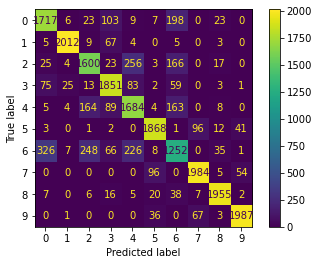

In [54]:
# Plot confusion matrix for predictions of regression model with L2 regularisation

plot_confusion_matrix(regr_l1, X_val, y_val)  
plt.show()  

Reference: https://medium.com/jovianml/logistic-regression-on-fashion-mnist-e3473ca496f0

### B2.4 Convolutional Neural networks

#### B2.4.a

In [55]:
%matplotlib inline
import time

from typing import Iterable
from torch.utils.data import DataLoader
from dataclasses import dataclass

# CNN Model with 2 convolution layers and 2 Fully connected layers

class NeuralNet22(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self._body = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )        
        
        self._head = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 10)
        )
        
        
        
    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

cnn = NeuralNet22()
print(cnn)

def get_data(batch_size, data_root="data", num_workers=1):
    
    train_test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    train_loader = DataLoader(
        datasets.FashionMNIST("data", train=True, download=True, transform=train_test_transforms),
        batch_size = batch_size,
        shuffle = True,
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        datasets.FashionMNIST("data", train=False, download=True, transform=train_test_transforms),
        batch_size = batch_size,
        shuffle = False,
        num_workers=num_workers
    )
    
    return train_loader, test_loader

@dataclass
class SystemConfiguration:
    # common system settings for reproducible results
    seed: int = 1748547
    cudnn_benchmark_enabled: bool = True
    cudnn_deterministic: bool = True

@dataclass
class TrainingConfiguration:
    # define training configuration
    
    batch_size: int = 32
    epochs_count: int = 35
    learning_rate: float = 0.001
    log_interval: int = 100
    test_interval: int = 1
    data_root: str = "data"
    num_workers: int = 1
    device: str = "cuda"

# System setup function

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# Training

def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# Validation

def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = NeuralNet22()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Epoch[{}], Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(epoch,
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

model22, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

NeuralNet22(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)
Epoch[0], Elapsed 16.46s, 16.46 s/epoch, 0.01 s/batch, ets 559.58s

Test set: Average loss: 1.0744, Accuracy: 6352/10000 (64%)

Epoch[1], Elapsed 32.39s, 16.19 s/epoch, 0.01 s/batch, ets 534.39s

Test set: Average loss: 0.7883, Accuracy: 7133/10000 (71%)

Epoch[2], Elapsed 48.43s, 16.14 s/epoch, 0.01 s/batch, ets 516.54s

Test set: Average loss: 0.7088, Accuracy: 7443/10000 (74%)

Epoch[3], Elapsed 64.77s, 16.19 s/epoch, 0.01 s/batch, et

#### B2.4.b

W_f = (W - F +2*P)/S + 1

In [59]:
# CNN Model with 2 convolution layers and 5 Fully connected layers

class NeuralNet25(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self._body = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5), #32-5 +1 = 28x28x6
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14x14
            nn.Conv2d(6, 16, kernel_size=5), # 14-5+1 = 10x10x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 5x5x16
        )        
        
        self._head = nn.Sequential(
            nn.Linear(16*5*5, 150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
        )   
        
    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

cnn = NeuralNet25()
print(cnn)

def get_data(batch_size, data_root="data", num_workers=1):
    
    train_test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    train_loader = DataLoader(
        datasets.FashionMNIST("data", train=True, download=True, transform=train_test_transforms),
        batch_size = batch_size,
        shuffle = True,
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        datasets.FashionMNIST("data", train=False, download=True, transform=train_test_transforms),
        batch_size = batch_size,
        shuffle = False,
        num_workers=num_workers
    )
    
    return train_loader, test_loader

@dataclass
class SystemConfiguration:
    # common system settings for reproducible results
    seed: int = 1748547
    cudnn_benchmark_enabled: bool = True
    cudnn_deterministic: bool = True

@dataclass
class TrainingConfiguration:
    # define training configuration
    
    batch_size: int = 32
    epochs_count: int = 35
    learning_rate: float = 0.001
    log_interval: int = 100
    test_interval: int = 1
    data_root: str = "data"
    num_workers: int = 1
    device: str = "cuda"

# System setup function

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# Training

def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# Validation

def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = NeuralNet25()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Epoch[{}], Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(epoch,
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

model25, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

NeuralNet25(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=120, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=120, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=84, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=84, out_features=10, bias=True)
  )
)
Epoch[0], Elapsed 13.24s, 13.24 s/epoch, 0.01 s/batch, ets 450.10s

Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10%)

Epoch[1], Elapsed 28.99s, 14.49 s/epoch, 0.01

#### B2.4.c

In [60]:
# CNN Model with 5 convolution layers and 2 Fully connected layers

class NeuralNet52(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self._body = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3), # 32-3+1 = 30
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 16, kernel_size=3), # 30 - 3 +1 = 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14 x14
            nn.Conv2d(16, 32, kernel_size=3), # 12 x 12
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3), # 10x 10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 5x5
            nn.Conv2d(64, 128, kernel_size=3), # 3 x 3 x 128
            nn.ReLU(inplace=True),
        )        
        
        self._head = nn.Sequential(
            nn.Linear(128*3*3, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 10)
        )     
        
    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

cnn = NeuralNet52()
print(cnn)

def get_data(batch_size, data_root="data", num_workers=1):
    
    train_test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    train_loader = DataLoader(
        datasets.FashionMNIST("data", train=True, download=True, transform=train_test_transforms),
        batch_size = batch_size,
        shuffle = True,
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        datasets.FashionMNIST("data", train=False, download=True, transform=train_test_transforms),
        batch_size = batch_size,
        shuffle = False,
        num_workers=num_workers
    )
    
    return train_loader, test_loader

@dataclass
class SystemConfiguration:
    # common system settings for reproducible results
    seed: int = 1748547
    cudnn_benchmark_enabled: bool = True
    cudnn_deterministic: bool = True

@dataclass
class TrainingConfiguration:
    # define training configuration
    
    batch_size: int = 32
    epochs_count: int = 35
    learning_rate: float = 0.001
    log_interval: int = 100
    test_interval: int = 1
    data_root: str = "data"
    num_workers: int = 1
    device: str = "cuda"

# System setup function

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# Training

def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# Validation

def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = NeuralNet52()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Epoch[{}], Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(epoch,
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

model52, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

NeuralNet52(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
  )
  (_head): Sequential(
    (0): Linear(in_features=1152, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)
Epoch[0], Elapsed 13.59s, 13.59 s/epoch, 0.01 s/batch, ets 462.00s

Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10%)

Epoch[1], Elapsed 29.92s, 14.96 s/epoch, 0.01 s/

### B3. Unsupervised learning on Fashion-MNIST

In [61]:
# Preparing data with 2 categories 0 (Top) and 7 (sneakers)

df = data_train[(data_train['Category'] == 0) | (data_train['Category'] == 7)]
df.shape

(12000, 786)

In [62]:
df = df.reset_index(drop=True)

In [63]:
df.head(11)

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
1,10,0,0,0,0,0,1,0,0,0,...,164,177,163,0,0,1,0,0,0,0
2,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,21,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24,0,0,0,0,0,0,0,0,0,...,125,93,87,49,0,0,0,0,0,0
5,28,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,31,0,0,0,0,0,0,0,0,0,...,154,118,66,0,0,0,0,0,0,0
7,35,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,41,0,0,0,0,0,0,0,2,23,...,11,0,0,0,0,0,0,0,0,0
9,44,0,0,0,0,0,0,1,1,0,...,107,100,44,0,2,0,0,0,0,0


#### B3.1.a

In [64]:
from sklearn.decomposition import PCA

In [65]:
X = df.drop(["Id", "Category"], axis=1)
y = df["Category"]

In [66]:
pca = PCA()

In [67]:
pca.fit(X)

PCA()

In [68]:
eigenvalues = pca.explained_variance_
egienvectors = pca.components_

In [69]:
eigen = list(zip(eigenvalues,egienvectors))

In [70]:
import operator

In [71]:
eigen = sorted(eigen, key=operator.itemgetter(0), reverse=True)

In [72]:
eigen = eigen[:24]

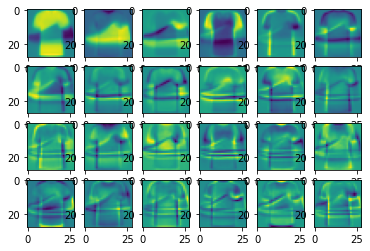

In [73]:
for idx, e in enumerate(eigen):
    plt.subplot(4, 6, idx+1)
    plt.imshow(e[1].reshape(28,28))

#### B3.1.b

In [74]:
mu = np.mean(X, axis=0)

In [75]:
df_0 = df[df["Category"] == 0]

In [76]:
df_0 = df_0.sample(15)

In [77]:
df_1 = df[df["Category"] == 7]

In [78]:
df_1 = df_1.sample(15)

In [79]:
df_test = pd.concat([df_0,df_1])

In [80]:
df_test = df_test.reset_index(drop=True)

In [81]:
x_origin = df_test.drop(["Id", "Category"], axis=1)

In [82]:
nComp = 24
Xhat = np.dot(pca.transform(x_origin)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu

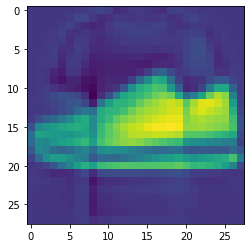

In [83]:
plt.imshow(Xhat[24].reshape(28,28))

In [84]:
type(Xhat)

numpy.ndarray

In [85]:
x_origin = x_origin.to_numpy()

In [86]:
e = Xhat - x_origin
np.sum(e*e, axis=1)/30

array([14843.49188663,  6263.35050611, 17522.90100643, 21137.27931383,
       17095.94969681, 15898.29956242,  7450.64688963, 20111.16560312,
       28624.18694946, 17008.93188693, 39215.7903784 , 21756.95252977,
       18074.49228661,  9524.12558581, 23958.03871145, 17145.54492004,
       12776.24907823, 21357.83600797, 13752.77003862, 15442.09671225,
       15292.40245592, 14982.41212294, 10437.31034244,  5221.34124125,
       16787.03206981, 65077.48507656, 24310.7070514 , 19651.25166293,
       19832.38861205, 17016.47860642])

In [87]:
x_origin.shape

(30, 784)

In [88]:
Xhat.shape

(30, 784)

In [89]:
x_origin = list(x_origin)
Xhat = list(Xhat)
x_origin.extend(Xhat)

In [90]:
x_origin = np.asarray(x_origin)

In [91]:
x_origin.shape

(60, 784)

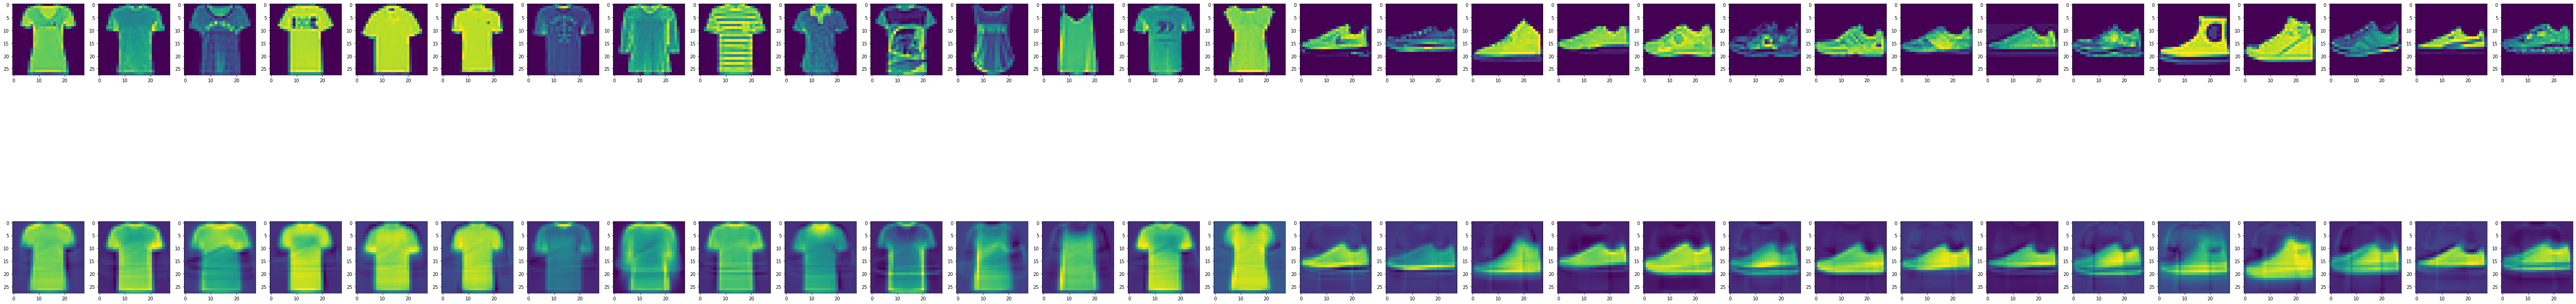

In [92]:
plt.figure(figsize=(100,16))
for idx, x in enumerate(x_origin): 
    plt.subplot(2,30, idx+1)
    plt.imshow(x.reshape(28,28))

#### B3.1.c

In [93]:
pca = PCA(n_components=2)

In [94]:
X_r = pca.fit(X).transform(X)

In [95]:
pca.components_.shape

(2, 784)

In [96]:
target_names = ('T-shirt/top', 'Sneaker')

In [97]:
colors = ['navy', 'darkorange']

In [98]:
lw = 2

In [99]:
y

0        0
1        0
2        0
3        7
4        0
        ..
11995    7
11996    0
11997    7
11998    0
11999    7
Name: Category, Length: 12000, dtype: int64

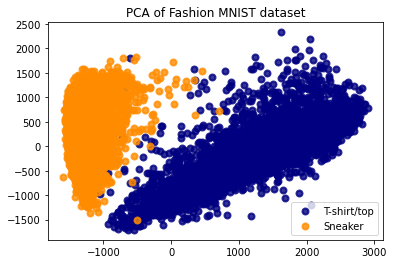

In [100]:
for color, i, target_name in zip(colors, [0, 7], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Fashion MNIST dataset')
    
plt.show()

#### B3.1.d

In [101]:
from sklearn.cluster import KMeans

In [102]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_r)

In [103]:
label = kmeans.fit_predict(X_r)

In [104]:
label

array([1, 1, 1, ..., 0, 1, 0])

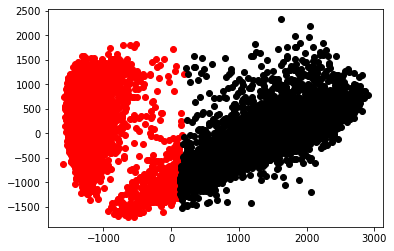

In [105]:
filtered_label0 = X_r[label == 0]
 
filtered_label7 = X_r[label == 1]
 
#Plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.scatter(filtered_label7[:,0] , filtered_label7[:,1] , color = 'black')
plt.show()

#### B3.2.a

In [106]:
class YourSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, mask, data_source):
        self.mask = mask
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(mask)])

    def __len__(self):
        return len(self.data_source)

mask = [1 if ((fmnist_data_train[i][1] == 0) or (fmnist_data_train[i][1] == 7)) else 0 for i in range(len(fmnist_data_train))]
mask = torch.tensor(mask)   
sampler = YourSampler(mask, fmnist_data_train)
trainloader = torch.utils.data.DataLoader(fmnist_data_train, batch_size=batch_size,sampler = sampler, shuffle=False, num_workers=2)

In [107]:
# constants
NUM_EPOCHS = 30
LEARNING_RATE = 1e-2
BATCH_SIZE = 128
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [108]:
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

In [109]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.enc2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(32, 64, kernel_size=7)
        self.enc4 = nn.Conv2d(64, 128, kernel_size=1)
        self.enc5 = nn.Conv2d(128, 256, kernel_size=1)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(256, 128, kernel_size=1)
        self.dec2 = nn.ConvTranspose2d(128, 64, kernel_size=1)
        self.dec3 = nn.ConvTranspose2d(64, 32, kernel_size=7)
        self.dec4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec5 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.dec5(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (enc4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (enc5): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (dec1): ConvTranspose2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (dec2): ConvTranspose2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (dec3): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (dec4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [110]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [111]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)   
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    return train_loss
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

In [112]:
import os
from torchvision.utils import save_image

cuda:0
Epoch 1 of 30, Train Loss: 0.149
Epoch 2 of 30, Train Loss: 0.141
Epoch 3 of 30, Train Loss: 0.141
Epoch 4 of 30, Train Loss: 0.141
Epoch 5 of 30, Train Loss: 0.141
Epoch 6 of 30, Train Loss: 0.141
Epoch 7 of 30, Train Loss: 0.141
Epoch 8 of 30, Train Loss: 0.141
Epoch 9 of 30, Train Loss: 0.141
Epoch 10 of 30, Train Loss: 0.141
Epoch 11 of 30, Train Loss: 0.141
Epoch 12 of 30, Train Loss: 0.141
Epoch 13 of 30, Train Loss: 0.141
Epoch 14 of 30, Train Loss: 0.141
Epoch 15 of 30, Train Loss: 0.141
Epoch 16 of 30, Train Loss: 0.141
Epoch 17 of 30, Train Loss: 0.141
Epoch 18 of 30, Train Loss: 0.141
Epoch 19 of 30, Train Loss: 0.141
Epoch 20 of 30, Train Loss: 0.141
Epoch 21 of 30, Train Loss: 0.141
Epoch 22 of 30, Train Loss: 0.141
Epoch 23 of 30, Train Loss: 0.141
Epoch 24 of 30, Train Loss: 0.141
Epoch 25 of 30, Train Loss: 0.141
Epoch 26 of 30, Train Loss: 0.141
Epoch 27 of 30, Train Loss: 0.141
Epoch 28 of 30, Train Loss: 0.141
Epoch 29 of 30, Train Loss: 0.141
Epoch 30 of 30, 

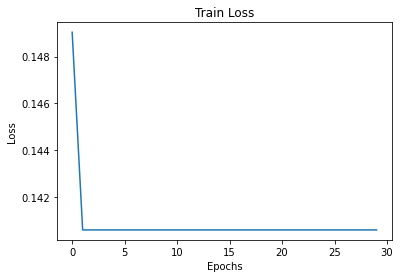

In [113]:
# get the computation device
print(device)
# load the neural network onto the device
net.to(device)
make_dir()
# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')
# test the network
test_image_reconstruction(net, testloader)

#### B3.2.b

In [114]:
class Autoencoder_mod(nn.Module):
    def __init__(self):
        super(Autoencoder_mod, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.enc2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(32, 64, kernel_size=7)
        self.enc4 = nn.Conv2d(64, 128, kernel_size=1)
        self.enc5 = nn.Conv2d(128, 1, kernel_size=1)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(1, 128, kernel_size=1)
        self.dec2 = nn.ConvTranspose2d(128, 64, kernel_size=1)
        self.dec3 = nn.ConvTranspose2d(64, 32, kernel_size=7)
        self.dec4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec5 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.dec5(x))
        return x
net = Autoencoder_mod()
print(net)

Autoencoder_mod(
  (enc1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (enc4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (enc5): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  (dec1): ConvTranspose2d(1, 128, kernel_size=(1, 1), stride=(1, 1))
  (dec2): ConvTranspose2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (dec3): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (dec4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [115]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [116]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            img = img.view(img.size(0), -1)
            outputs = outputs.view(outputs.size(0), -1)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    return train_loss
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = net(img)
        img = img.view(img.size(0), -1)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

In [117]:
import os
from torchvision.utils import save_image

cuda:0
Epoch 1 of 30, Train Loss: 0.157
Epoch 2 of 30, Train Loss: 0.141
Epoch 3 of 30, Train Loss: 0.141
Epoch 4 of 30, Train Loss: 0.141
Epoch 5 of 30, Train Loss: 0.141
Epoch 6 of 30, Train Loss: 0.141
Epoch 7 of 30, Train Loss: 0.141
Epoch 8 of 30, Train Loss: 0.141
Epoch 9 of 30, Train Loss: 0.141
Epoch 10 of 30, Train Loss: 0.141
Epoch 11 of 30, Train Loss: 0.141
Epoch 12 of 30, Train Loss: 0.141
Epoch 13 of 30, Train Loss: 0.141
Epoch 14 of 30, Train Loss: 0.141
Epoch 15 of 30, Train Loss: 0.141
Epoch 16 of 30, Train Loss: 0.141
Epoch 17 of 30, Train Loss: 0.141
Epoch 18 of 30, Train Loss: 0.141
Epoch 19 of 30, Train Loss: 0.141
Epoch 20 of 30, Train Loss: 0.141
Epoch 21 of 30, Train Loss: 0.141
Epoch 22 of 30, Train Loss: 0.141
Epoch 23 of 30, Train Loss: 0.141
Epoch 24 of 30, Train Loss: 0.141
Epoch 25 of 30, Train Loss: 0.141
Epoch 26 of 30, Train Loss: 0.141
Epoch 27 of 30, Train Loss: 0.141
Epoch 28 of 30, Train Loss: 0.141
Epoch 29 of 30, Train Loss: 0.141
Epoch 30 of 30, 

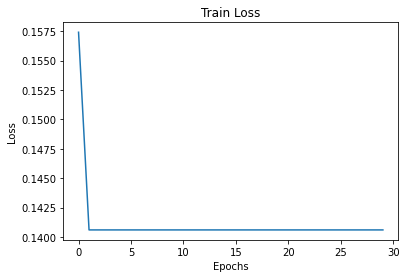

In [118]:
# get the computation device
print(device)
# load the neural network onto the device
net.to(device)
make_dir()
# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')
# test the network
test_image_reconstruction(net, testloader)